In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# time series - statsmodels
# Seasonality decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
# holt winters
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Data Preparation

In [ ]:
df_make = pd.read_csv("/content/gdrive/MyDrive/SCA Project/Datasets/norway_new_car_sales_by_make.csv")
df_model = pd.read_csv("/content/gdrive/MyDrive/SCA Project/Datasets/norway_new_car_sales_by_model.csv", encoding = "cp1252")
df_month = pd.read_csv("/content/gdrive/MyDrive/SCA Project/Datasets/norway_new_car_sales_by_month.csv")

In [ ]:
df_month['date'] = pd.to_datetime(df_month[['Year', 'Month']].assign(DAY=1))
df_make['date'] = pd.to_datetime(df_make[['Year', 'Month']].assign(DAY=1))
df_model['date'] = pd.to_datetime(df_model[['Year', 'Month']].assign(DAY=1))

In [ ]:
df_make = df_make.sort_values(by='date')
df_model = df_model.sort_values(by='date')
df_month = df_month.sort_values(by='date')

In [ ]:
# drop 2017 data
df_make.drop(df_make[df_make['Year'] == 2017].index, axis=0, inplace=True)
df_model.drop(df_model[df_model['Year'] == 2017].index, axis=0, inplace=True)
df_month.drop(df_month[df_month['Year'] == 2017].index, axis=0, inplace=True)

In [ ]:
# check null values
print("df_make null values\n", df_make.isnull().sum()[df_make.isnull().sum() > 0])   # drop records without 'Make'
print("\ndf_model null values\n", df_model.isnull().sum()[df_model.isnull().sum() > 0])
print("\ndf_month null values\n", df_month.isnull().sum()[df_month.isnull().sum() > 0])  # Used and Used_YOY are not used, just leave them be. Impute quantity related features with 0

df_make null values
 Make    10
dtype: int64

df_model null values
 Series([], dtype: int64)

df_month null values
 Used                 60
Used_YoY             72
Quantity_Hybrid      48
Quantity_Electric    48
Import_Electric      68
dtype: int64


In [ ]:
# deal with null values
df_make = df_make[df_make['Make'].notnull()]    # drop records without 'Make'
df_month[['Import_Electric', 'Quantity_Electric', 'Quantity_Hybrid']] = df_month[['Import_Electric', 'Quantity_Electric', 'Quantity_Hybrid']].fillna(0)   # fillna for electric related features and leave `Used` related features be

# 1. EDA on Car Sales Market in Norway

## Car Market Analysis in Norway (2007-2016)

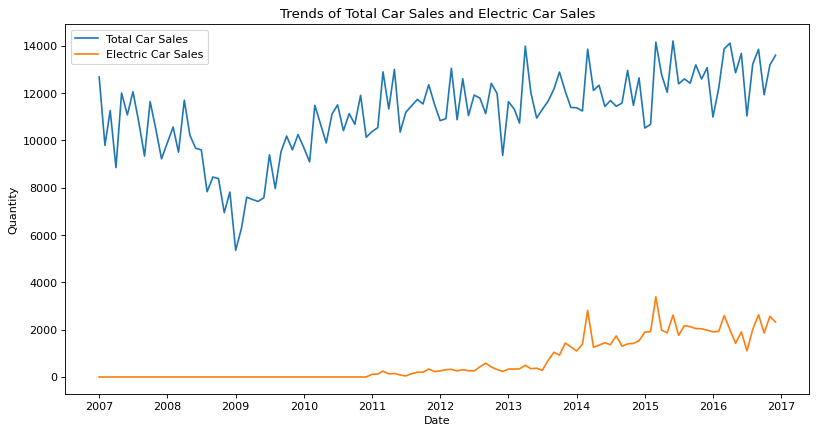

In [ ]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(df_month['date'], df_month['Quantity'], label='Total Car Sales')
plt.plot(df_month['date'], df_month['Quantity_Electric'], label='Electric Car Sales')

plt.title('Trends of Total Car Sales and Electric Car Sales')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

## Best-Selling Car Models Across The Years (2007-2016)

In [ ]:
# Get the top 10 car models by sales quantity
top_models = df_model.groupby('Model')['Quantity'].sum().index.tolist()

# Filter the dataset for the top 10 models
models_data = df_model[df_model['Model'].isin(top_models)]

# Pivot the data to create a model performance dataframe
model_sales_by_year = df_model.pivot_table(index='Year', columns='Model', values='Quantity', aggfunc='sum').fillna(0)
desc_sequence = df_model.groupby('Model')['Quantity'].sum().sort_values(ascending=False).index
top10_models = model_sales_by_year.loc[:, desc_sequence[:10]]

In [ ]:
top10_models.columns

Index(['Volkswagen Golf', 'Volkswagen Passat', 'Toyota Auris', 'Skoda Octavia',
       'Volvo V70', 'Toyota Yaris', 'Toyota Avensis', 'Nissan Qashqai',
       'Ford Focus', 'Toyota Rav4'],
      dtype='object', name='Model')

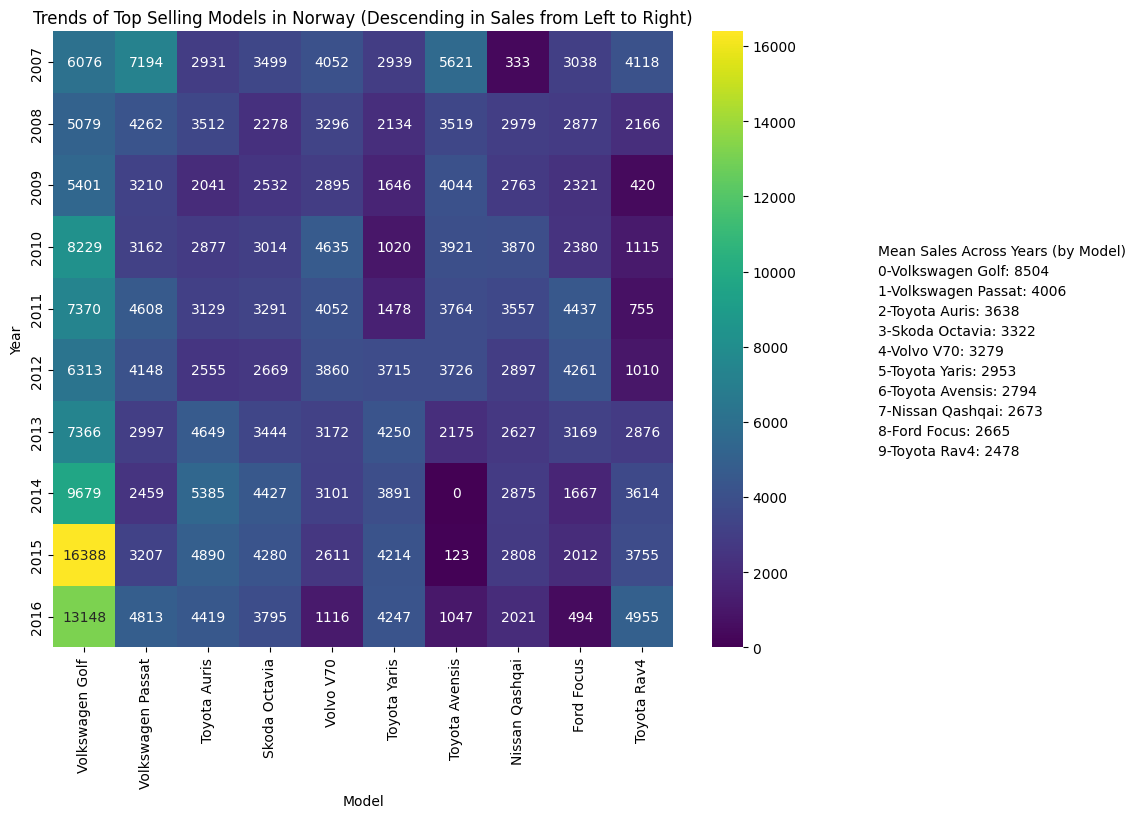

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(10, 8))
ax = sns.heatmap(top10_models.astype(int), cmap='viridis', annot=True, fmt='d')

plt.title("Trends of Top Selling Models in Norway (Descending in Sales from Left to Right)")

# Calculate the size of the legend subplot
legend_width = 0.3  # Adjust as desired
legend_height = 0.5 # Adjust as desired

# Add the legend subplot
# Calculate the mean value for each column
column_means = top10_models.mean()

ax2 = fig.add_axes([0.8, 0.1, legend_width, legend_height])
ax2.text(0.5, 1,"Mean Sales Across Years (by Model)", ha='left')
ax2.axis('off')
for i, (model, quantity) in enumerate(zip(top10_models.columns, column_means)):
    text = f"{i}-{model}: {int(quantity)}"
    ax2.text(0.5, 0.95 - i * 0.05, text, transform=ax2.transAxes, ha='left')

# Create a colorbar
plt.show()

<Axes: xlabel='Year'>

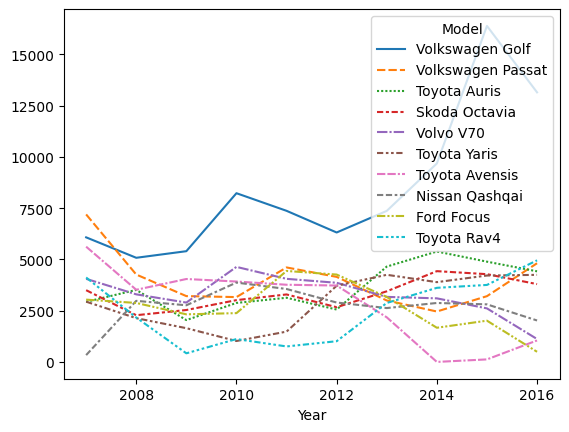

In [ ]:
sns.lineplot(top10_models)

While we notice the sales of cars rising significantly after 2013, we can notice that none of the top selling car models are electric car. This shows that there is no single electric car model that is strong enough to compete in the mass market in the Norwegian market yet.
<br>

### Exploring the Growth Potential of Electric Cars

As electric car is a growing market instead of a matured market, the more appropriate metric to evaluate it is through growth rate instead of existing sales. Therefore, the car models with highest growth rate since 2011 (electric car is only available after 2011 in Norway) are investigated.

Text(0, 0.5, 'Car Models')

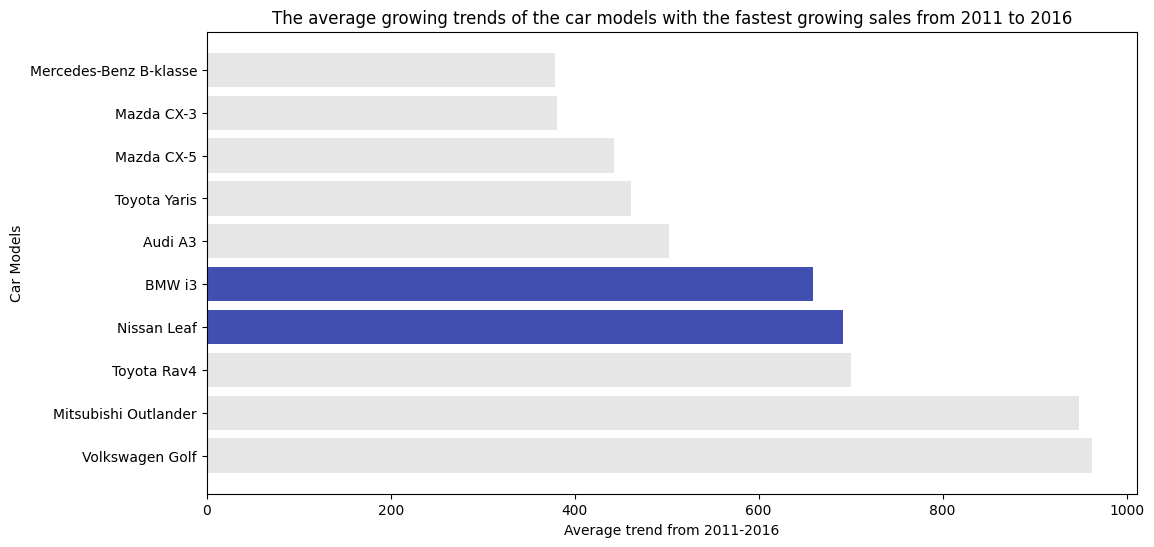

In [ ]:
# find the models with fastest growing speed from year 2011 (EV only available after 2011)
model_sales_growth =  model_sales_by_year.loc[2011:].diff().fillna(0)
growth_descending_order = model_sales_by_year.loc[2011:].diff().fillna(0).mean().sort_values(ascending=False).index
fastest_growing_models = model_sales_growth.loc[:, growth_descending_order[:10]]

top10_growing_trends_post_2011 = model_sales_by_year.loc[2011:].diff().fillna(0).mean().sort_values(ascending=False)[:10]

# plot the trends of fastest growing car models
fig, ax = plt.subplots(figsize=(12,6))
ax.barh(top10_growing_trends_post_2011.index, top10_growing_trends_post_2011, align='center',
        color=['#414fb1' if i in ['BMW i3', 'Nissan Leaf'] else '#e6e6e6' for i in top10_growing_trends_post_2011.index])

ax.set_title("The average growing trends of the car models with the fastest growing sales from 2011 to 2016")
ax.set_xlabel("Average trend from 2011-2016")
ax.set_ylabel("Car Models")

Nonetheless, if we look at the cars with fastest average growing trends since 2011, two electric car models, i.e. `Nissan Leaf` and `BMW i3` are ranked 4th and 5th. This shows that there was a huge potential for the growth of electric car sales, especially when there were very few competitions in the market.

## Paradigm Shift from the Conventional Market: Electric Car and Carbon Emission

One of the main selling points of electric cars is their relatively low environment impact as they do not release CO2.

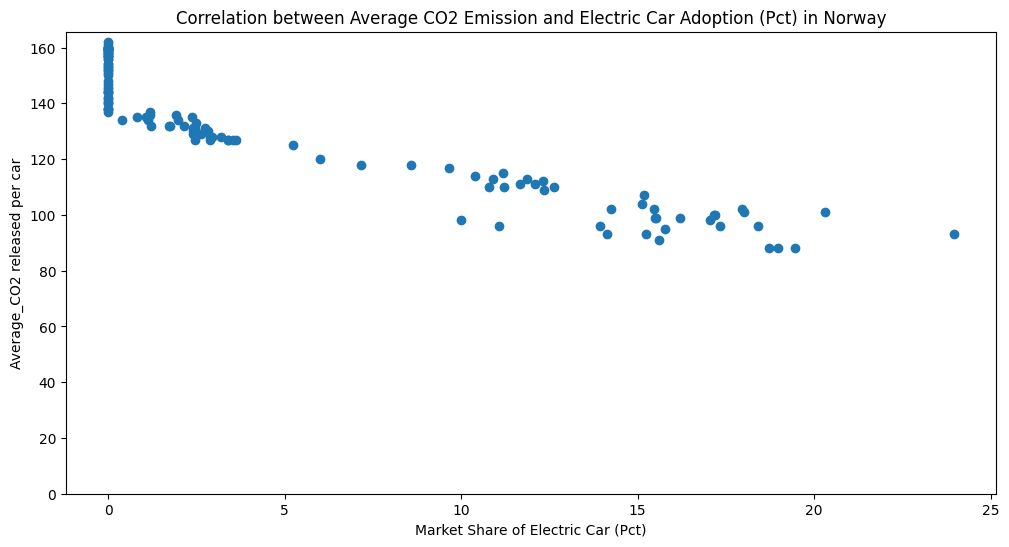

In [ ]:
df_month['Pct_Electric'] = df_month['Quantity_Electric'] / df_month['Quantity'] * 100

# explore correlation between electric car market share and average carbon dioxide emission
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df_month['Pct_Electric'], df_month['Avg_CO2'], label='Average CO2')

ax.set_ylabel("Average_CO2 released per car")
ax.set_xlabel("Market Share of Electric Car (Pct)")
ax.set_ylim([0, None])
ax.set_title("Correlation between Average CO2 Emission and Electric Car Adoption (Pct) in Norway")
plt.show()


By eyeballing the graph, we can notice that the average CO2 released by car reduce with the increase in the market share of electric car.

In [ ]:
import statsmodels.api as sm

X = df_month['Pct_Electric']
Y = df_month['Avg_CO2']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                Avg_CO2   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     681.6
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           7.42e-51
Time:                        12:21:23   Log-Likelihood:                -428.19
No. Observations:                 120   AIC:                             860.4
Df Residuals:                     118   BIC:                             866.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          146.5603      1.015    144.341   

By doing OLS regression, we can verify the correlation with the high R-squared value of 0.852. The model also shows that the model has a negative coefficient of -3.0341.
<br>

This shows that the negative correlation between increase in electric car market share and average CO2 emission of car. The fact that there was such a strong relationship suggests that the state powers should be very motivated to incentivize the increase of market share of electric cars as part of sustainability economy transition.

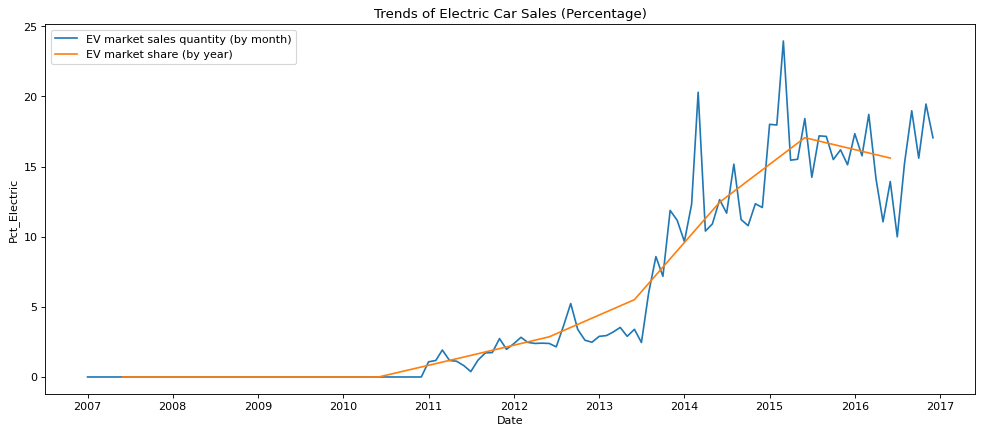

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)

# plot electric car market by month
plt.plot(df_month['date'], df_month['Pct_Electric'], label='EV market sales quantity (by month)')


# plot electric car market by year
years = df_month.groupby('Year')['Pct_Electric'].mean().reset_index()
years_ = pd.to_datetime(years['Year'].astype(str) + '-06-01')    # make average of each year to be on 06-01

plt.plot(years_, years['Pct_Electric'], label='EV market share (by year)')

plt.title('Trends of Electric Car Sales (Percentage)')
plt.xlabel('Date')
plt.ylabel('Pct_Electric')
plt.legend()

plt.show()

The time-series plot on the graph above showcases the trend of electric car market share in Norway, which has been increasing rapidly since 2011, but came to a plateau since mid-2015.

# Forecast Analytics

The future of the general and electric car market is estimated with time-series forecast. Multiple forecasting models such as moving average, exponential smoothing and ARIMA model are explored and evaluated in the following session. The best performing models are used to forecast car sales and electric car sales respectively in 2017.

**Evaluation of Models**
<br>

To ensure a more comprehensive and unbiased evaluation of forecast models, time series cross-validation is used. In this approach, an "expanding window", i.e.  a portion of the historical data is used to train the time-series forecasting model. The model is then evaluated by making predictions on the subsequent time period that falls outside the training window. The window is then expanded forward in time for the next fold, and the process is repeated until all available data is used for testing.



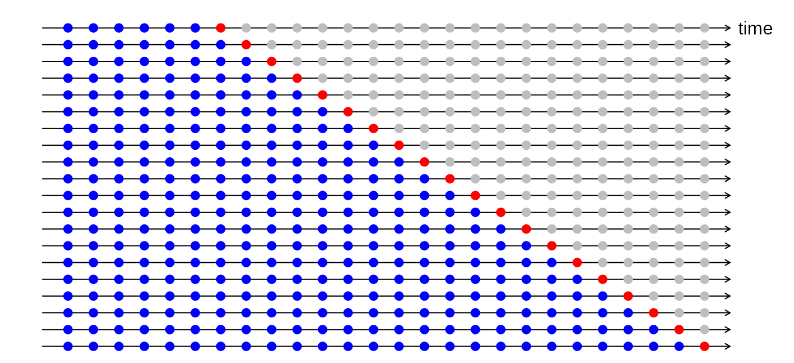

image from: https://otexts.com/fpp2/accuracy.html

In [ ]:
# prepare data
df_car_sales=df_month[['date','Quantity', 'Pct_Electric', 'Quantity_Electric']].copy()

## Forecasting Total Car Sales

### forecast method 1: Simple Moving Average

In [ ]:
# smoothen out the report by quarter / by year with simple moving average (to find out about the real trend of EV market share)
window_size = 12

# car sales MA
df_car_sales['12MA_Quantity'] = df_car_sales['Quantity'].rolling(window_size, center=False).mean()
df_car_sales['Forecast_Quantity'] = df_car_sales['12MA_Quantity'].shift()

# Extend for the forecasted years
df_car_sales.tail(3)

,date,Quantity,Pct_Electric,Quantity_Electric,12MA_Quantity,Forecast_Quantity
117,2016-10-01,11932,15.596715,1861.0,12790.416667,12895.833333
118,2016-11-01,13194,19.455813,2567.0,12839.916667,12790.416667
119,2016-12-01,13602,17.048963,2319.0,12883.583333,12839.916667


cv_RMSE: 993.6722006716543 cv_MSE: 1008606.3208333334 cv_MAE: 813.15 cv_MAPE: 0.0660812764913094


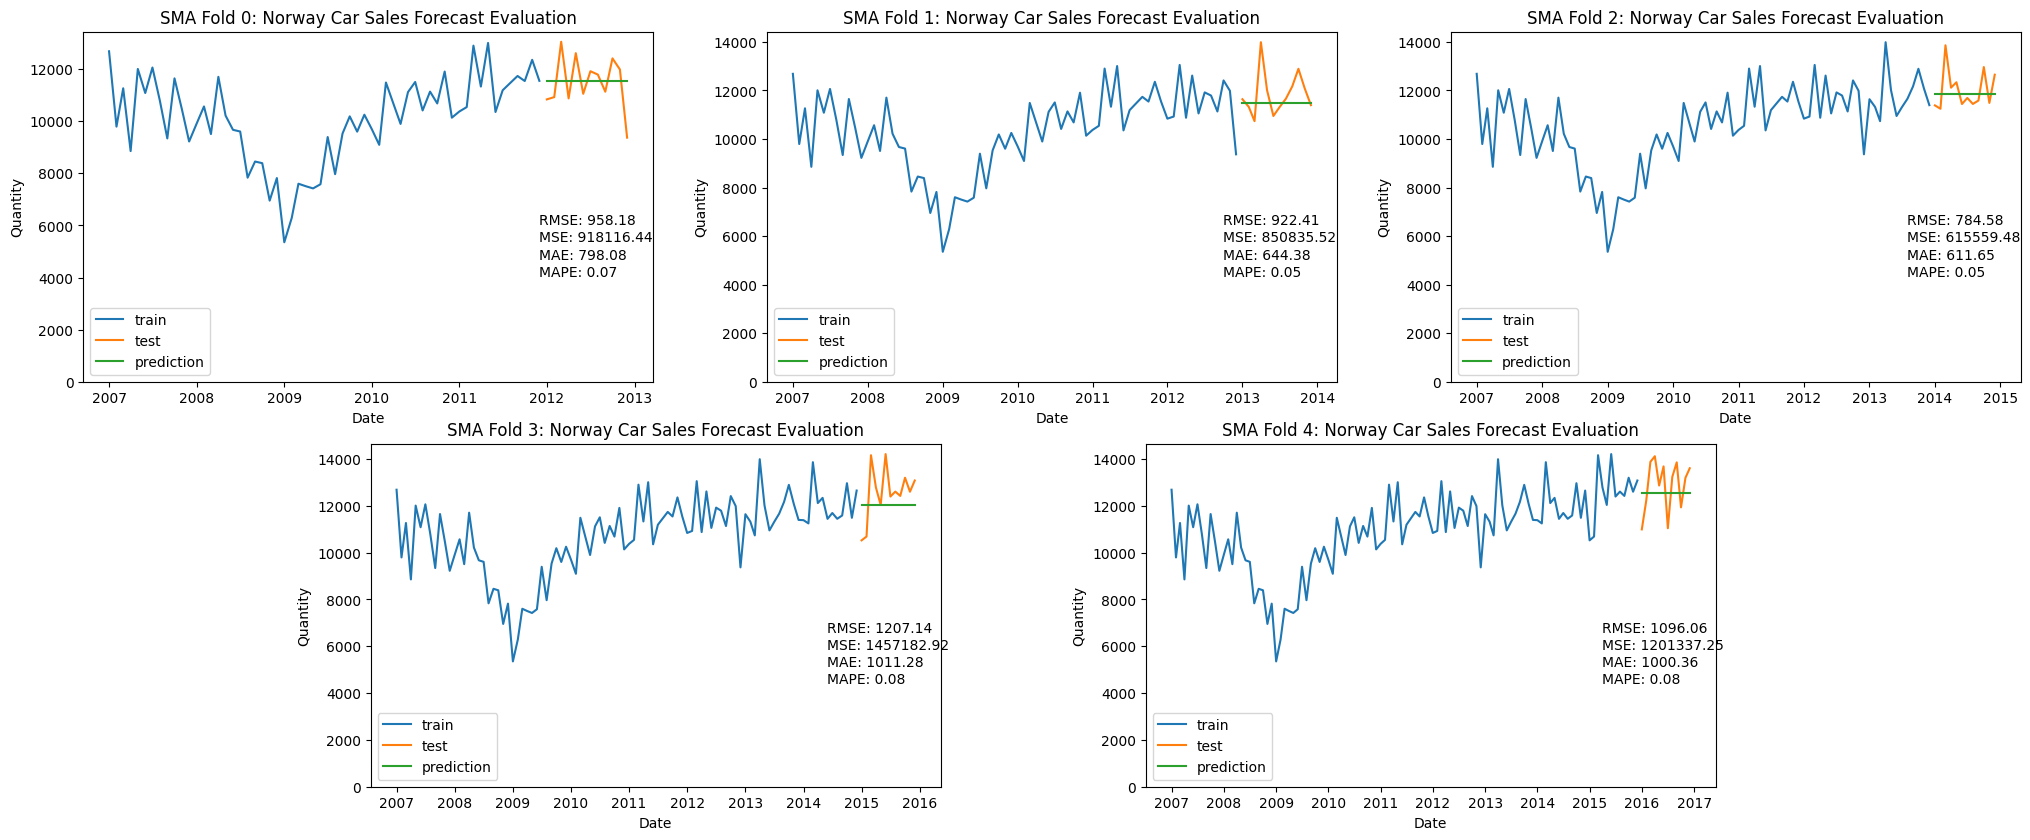

In [ ]:
# time series split
from sklearn.model_selection import TimeSeriesSplit
test_size =12
tscv = TimeSeriesSplit(n_splits = 5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales)):
  cv_train, cv_test = df_car_sales.loc[train_index, :], df_car_sales.loc[test_index, :]                                    # retrieve training set and testing set
  predictions = np.array(cv_train.loc[:,'12MA_Quantity'].tail(1).tolist() * test_size)                                                                          # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend()
  axes[i].set_title(f"SMA Fold {i}: Norway Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, None])

  axes[i].text(0.8, 0.45, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.4, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.35, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.3, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("cv_RMSE:", np.mean(rmse), "cv_MSE:", np.mean(mse), "cv_MAE:", np.mean(mae), "cv_MAPE:", np.mean(mape))

### forecast method 2: Simple Exponential Moving Average

cv_RMSE: 1070.3511316129507 cv_MSE: 1183597.6240132928 cv_MAE: 865.7228389811684 cv_MAPE: 0.0711481335430056
optimal smoothing level 0.4256744171145351


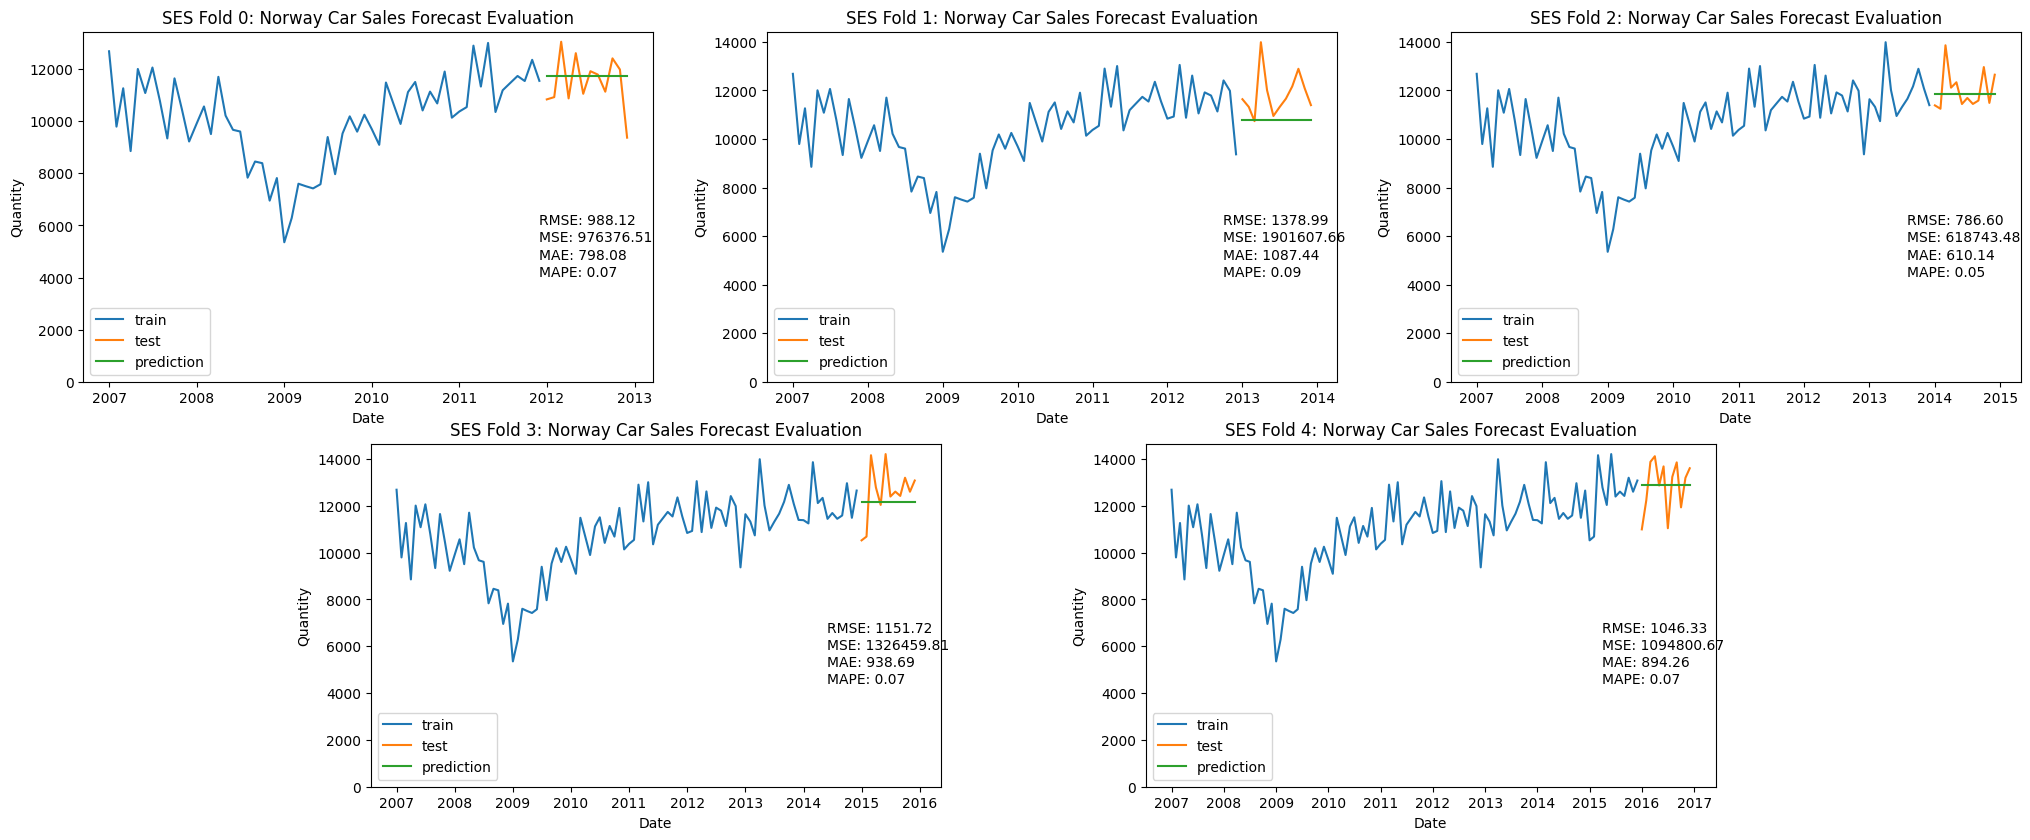

In [ ]:
# time series split
from sklearn.model_selection import TimeSeriesSplit
test_size = 12
tscv = TimeSeriesSplit(n_splits =5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales)):
  cv_train, cv_test = df_car_sales.loc[train_index, :], df_car_sales.loc[test_index, :]                                 # retrieve training set and testing set
  simple_exp_model = SimpleExpSmoothing(cv_train['Quantity']).fit(optimized=True)                                  # call model and fit; fit(optimized=True) will get optimal smoothing_level with built in optimization function
  predictions = simple_exp_model.forecast(test_size)                                                                           # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend()
  axes[i].set_title(f"SES Fold {i}: Norway Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, None])

  axes[i].text(0.8, 0.45, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.4, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.35, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.3, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("cv_RMSE:", np.mean(rmse), "cv_MSE:", np.mean(mse), "cv_MAE:", np.mean(mae), "cv_MAPE:", np.mean(mape))
print('optimal smoothing level', simple_exp_model.params['smoothing_level'])

### forecast method 3: Holt's Linear Model

cv_RMSE: 1046.1567313628143 cv_MSE: 1125331.0049886394 cv_MAE: 824.6726877784619 cv_MAPE: 0.06830136369468146
optimal smoothing level 0.33612718945750664 
optimal smoothing trend 0.013981560350161798


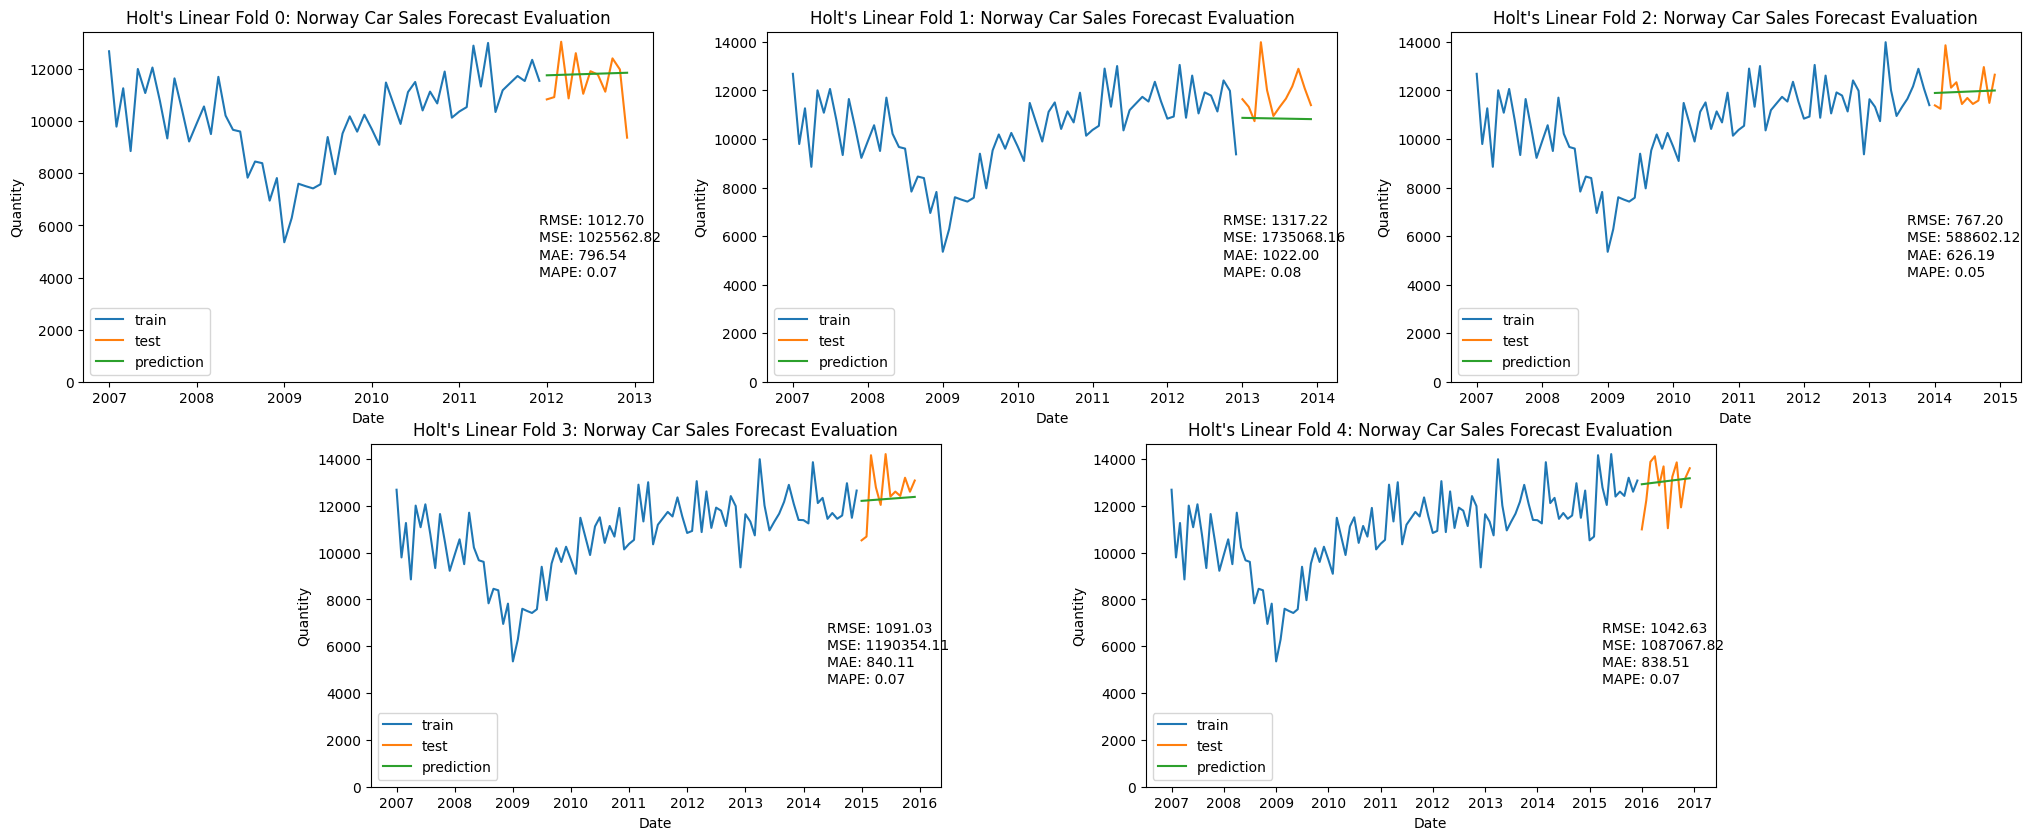

In [ ]:
# time series split
from sklearn.model_selection import TimeSeriesSplit
test_size = 12
tscv = TimeSeriesSplit(n_splits = 5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales)):
  cv_train, cv_test = df_car_sales.loc[train_index, :], df_car_sales.loc[test_index, :]                                 # retrieve training set and testing set
  holt_linear_model = ExponentialSmoothing(cv_train['Quantity'],trend='add').fit()   # call model and fit
  predictions = holt_linear_model.forecast(test_size)                                                                           # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend()
  axes[i].set_title(f"Holt's Linear Fold {i}: Norway Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, None])

  axes[i].text(0.8, 0.45, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.4, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.35, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.3, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("cv_RMSE:", np.mean(rmse), "cv_MSE:", np.mean(mse), "cv_MAE:", np.mean(mae), "cv_MAPE:", np.mean(mape))
print('optimal smoothing level', holt_linear_model.params['smoothing_level'],
      '\noptimal smoothing trend', holt_linear_model.params['smoothing_trend'])

### forecast method 4: ARIMA model

As ARIMA models requires stationarity, stationality of the data is tested with ADFuller test. If data is not stationary, data is differentiated until stationarity is achieved. Typically, differencing is carried out for less than 2 orders of differentiation.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
  result=adfuller(sales)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
  for value,label in zip(result,labels):
      print(label+' : '+str(value) )

  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
  else:
      print("weak evidence against null hypothesis,indicating it is non-stationary ")
  return result

result_ori = adfuller_test(df_car_sales.Quantity)
print()
result_d1 = adfuller_test(df_car_sales.Quantity.diff().dropna())   # d = 1 in ARIMA model


ADF Test Statistic : -0.9974995758652656
p-value : 0.7541751805790848
#Lags Used : 11
Number of Observations : 108
weak evidence against null hypothesis,indicating it is non-stationary 

ADF Test Statistic : -4.009292850066196
p-value : 0.0013626252810664658
#Lags Used : 10
Number of Observations : 108
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


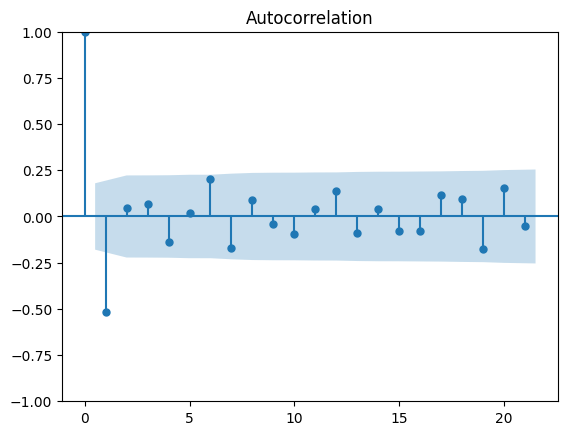

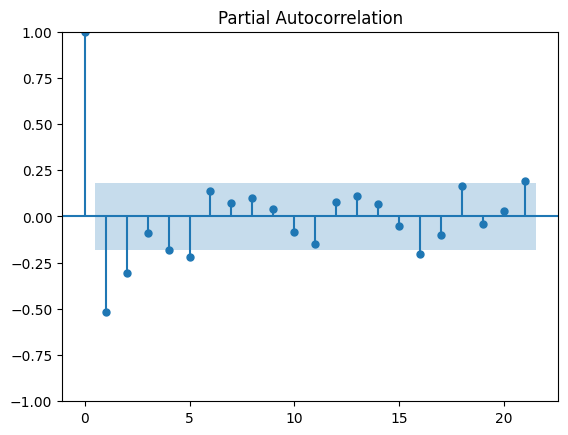

In [ ]:
# acf (autocorrelated function) and pacf (partially-autocorrelated function) are used to determine p and q
# reference: https://blog.devgenius.io/finding-optimal-p-d-and-q-values-for-your-arima-model-94669a909a35
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_d1 = plot_acf(df_car_sales.Quantity.diff().dropna())     # used to determine q (lag_time forecast error) : 1
pacf_d1 = plot_pacf(df_car_sales.Quantity.diff().dropna())   # used to determine p (autoregressive term): 2

all folds evaluation: 
cv_RMSE: 1077.498319108095 
cv_MSE: 1203533.8325586338 
cv_MAE: 870.7699274693177 
cv_MAPE: 0.07172234645595132


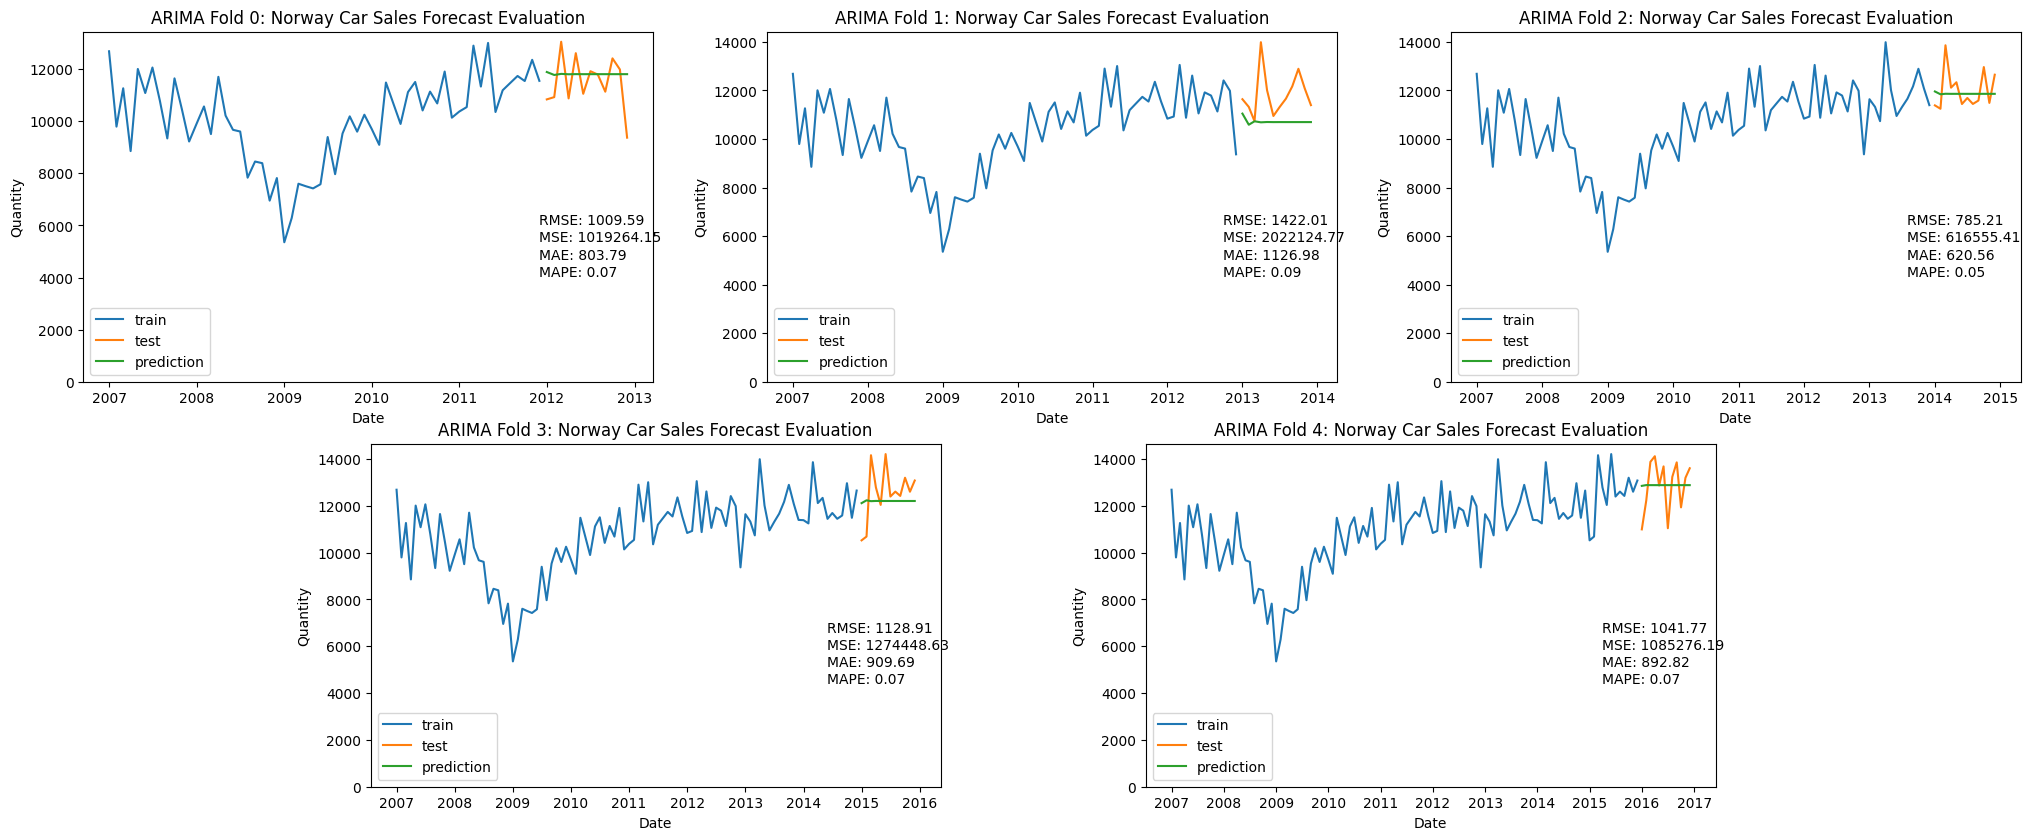

In [ ]:
# evaluate for ARIMA

# time series split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

test_size = 12
tscv = TimeSeriesSplit(n_splits = 5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales)):
  cv_train, cv_test = df_car_sales.loc[train_index, :], df_car_sales.loc[test_index, :]             # retrieve training set and testing set
  arima_model = ARIMA(cv_train['Quantity'], order = [2,1,1]).fit()                                  # call model and fit   (try out different combinations of order and explain)
  predictions = arima_model.forecast(test_size)                                                     # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend()
  axes[i].set_title(f"ARIMA Fold {i}: Norway Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, None])

  axes[i].text(0.8, 0.45, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.4, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.35, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.8, 0.3, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("all folds evaluation:", "\ncv_RMSE:", np.mean(rmse), "\ncv_MSE:", np.mean(mse),
      "\ncv_MAE:", np.mean(mae), "\ncv_MAPE:", np.mean(mape))

## Forecasting Electric Car Sales

### forecast method 1: Simple Moving Average

In [ ]:
# smoothen out the report by quarter / by year with simple moving average (to find out about the real trend of EV market share)
window_size = 12

# EV market share
df_car_sales['12MA_Quantity_Electric'] = df_car_sales['Quantity_Electric'].rolling(window_size, center=False).mean()
df_car_sales['Forecast_QE'] = df_car_sales['12MA_Quantity_Electric'].shift()

# Extend for the forecasted years
df_car_sales.head(3)

,date,Quantity,Pct_Electric,Quantity_Electric,12MA_Quantity,Forecast_Quantity,12MA_Quantity_Electric,Forecast_QE
0,2007-01-01,12685,0.0,0.0,NaN,NaN,NaN,NaN
1,2007-02-01,9793,0.0,0.0,NaN,NaN,NaN,NaN
2,2007-03-01,11264,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
# electric car sales only start from 2011
df_car_sales_QE = df_car_sales.loc[df_car_sales.date >= pd.to_datetime('2011')].reset_index(drop=True)
df_car_sales_QE

,date,Quantity,Pct_Electric,Quantity_Electric,12MA_Quantity,Forecast_Quantity,12MA_Quantity_Electric,Forecast_QE
0,2011-01-01,10372,1.079830,112.0,10702.416667,10646.166667,9.333333,0.000000
1,2011-02-01,10543,1.176136,124.0,10823.166667,10702.416667,19.666667,9.333333
2,2011-03-01,12901,1.922332,248.0,10941.083333,10823.166667,40.333333,19.666667
3,2011-04-01,11330,1.173875,133.0,10995.500000,10941.083333,51.416667,40.333333
4,2011-05-01,13005,1.122645,146.0,11254.583333,10995.500000,63.583333,51.416667
...,...,...,...,...,...,...,...,...
67,2016-08-01,13232,15.220677,2014.0,12776.416667,12724.083333,1921.833333,1934.500000
68,2016-09-01,13854,18.976469,2629.0,12895.833333,12776.416667,1963.416667,1921.833333
69,2016-10-01,11932,15.596715,1861.0,12790.416667,12895.833333,1948.083333,1963.416667
70,2016-11-01,13194,19.455813,2567.0,12839.916667,12790.416667,1992.000000,1948.083333


cv_RMSE: 576.3587225498776 
cv_MSE: 400885.8333333334 
cv_MAE: 474.4888888888889 
cv_MAPE: 0.37006502518469964


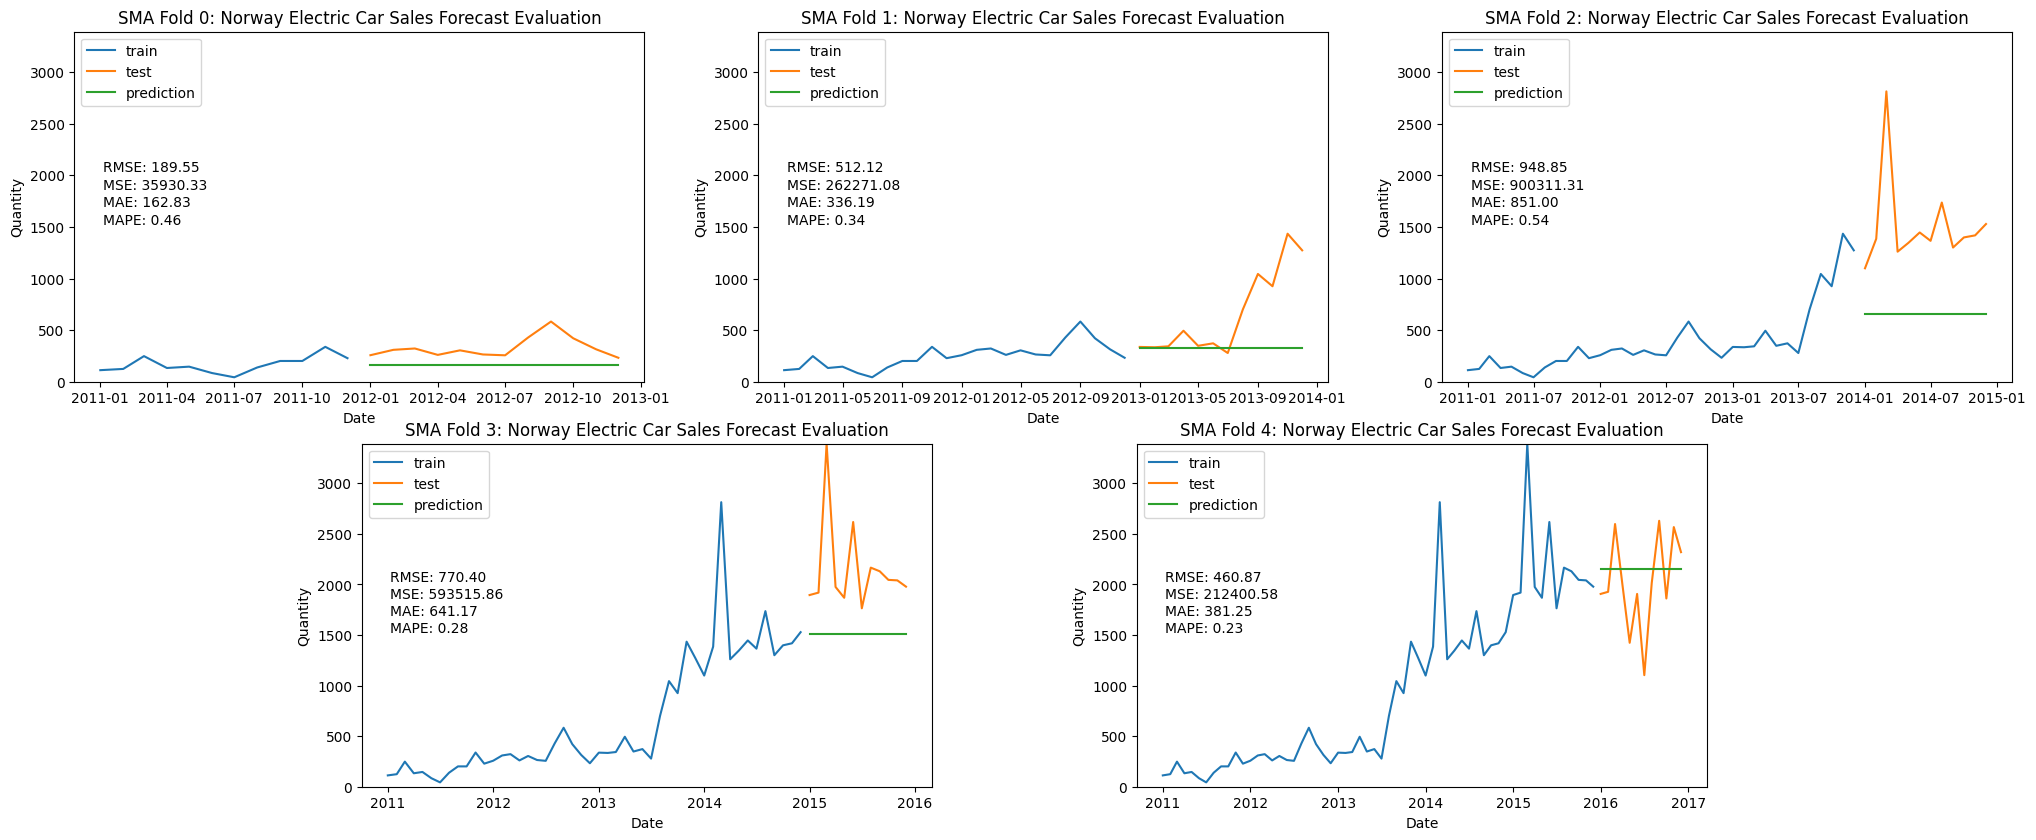

In [ ]:
# time series split
from sklearn.model_selection import TimeSeriesSplit
test_size =12
tscv = TimeSeriesSplit(n_splits = 5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales_QE)):
  cv_train, cv_test = df_car_sales_QE.loc[train_index, :], df_car_sales_QE.loc[test_index, :]                                    # retrieve training set and testing set
  predictions = np.array(cv_train.loc[:,'12MA_Quantity_Electric'].tail(1).tolist() * test_size)                                                                          # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity_Electric'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity_Electric'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity_Electric'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity_Electric'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity_Electric'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity_Electric'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend(loc='upper left')
  axes[i].set_title(f"SMA Fold {i}: Norway Electric Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, max(df_car_sales_QE.Quantity_Electric)])

  axes[i].text(0.05, 0.6, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.55, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.5, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.45, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("cv_RMSE:", np.mean(rmse), "\ncv_MSE:", np.mean(mse), "\ncv_MAE:", np.mean(mae), "\ncv_MAPE:", np.mean(mape))

### forecast method 2: Simple Exponential Moving Average

cv_RMSE: 484.5636703007299 
cv_MSE: 282672.26719108305 
cv_MAE: 356.7957715555763 
cv_MAPE: 0.26817141511793324
optimal smoothing level 0.4118920648997151


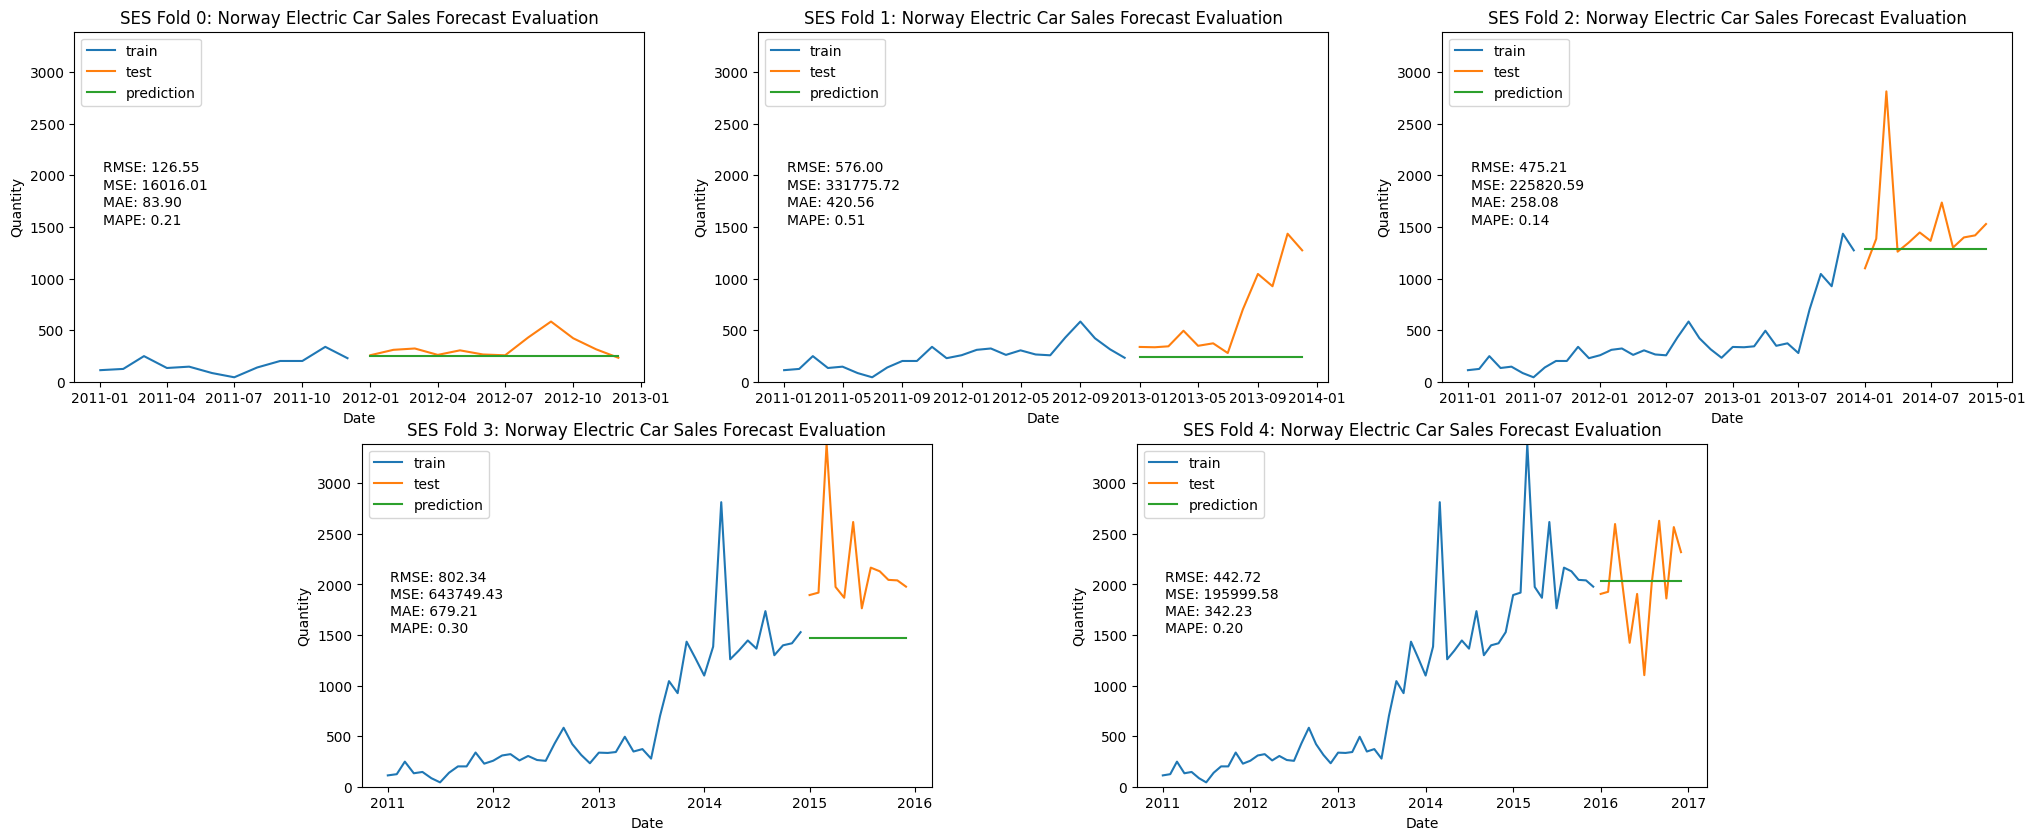

In [ ]:
# time series split
from sklearn.model_selection import TimeSeriesSplit
test_size = 12
tscv = TimeSeriesSplit(n_splits =5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales_QE)):
  cv_train, cv_test = df_car_sales_QE.loc[train_index, :], df_car_sales_QE.loc[test_index, :]                                  # retrieve training set and testing set
  simple_exp_model = SimpleExpSmoothing(cv_train['Quantity_Electric']).fit(optimized=True)                                  # call model and fit; fit(optimized=True) will get optimal smoothing_level with built in optimization function
  predictions = simple_exp_model.forecast(test_size)                                                                           # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity_Electric'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity_Electric'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity_Electric'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity_Electric'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity_Electric'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity_Electric'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend(loc='upper left')
  axes[i].set_title(f"SES Fold {i}: Norway Electric Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, max(df_car_sales_QE.Quantity_Electric)])

  axes[i].text(0.05, 0.6, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.55, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.5, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.45, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("cv_RMSE:", np.mean(rmse), "\ncv_MSE:", np.mean(mse), "\ncv_MAE:", np.mean(mae), "\ncv_MAPE:", np.mean(mape))
print('optimal smoothing level', simple_exp_model.params['smoothing_level'])

### forecast method 3: Holt-Linear Model

cv_RMSE: 457.67169372008414 
cv_MSE: 245300.9967993439 
cv_MAE: 326.6558710589296 
cv_MAPE: 0.2584262111982095
optimal smoothing level 0.3239155961594961 
optimal smoothing trend 0.024829340538840127


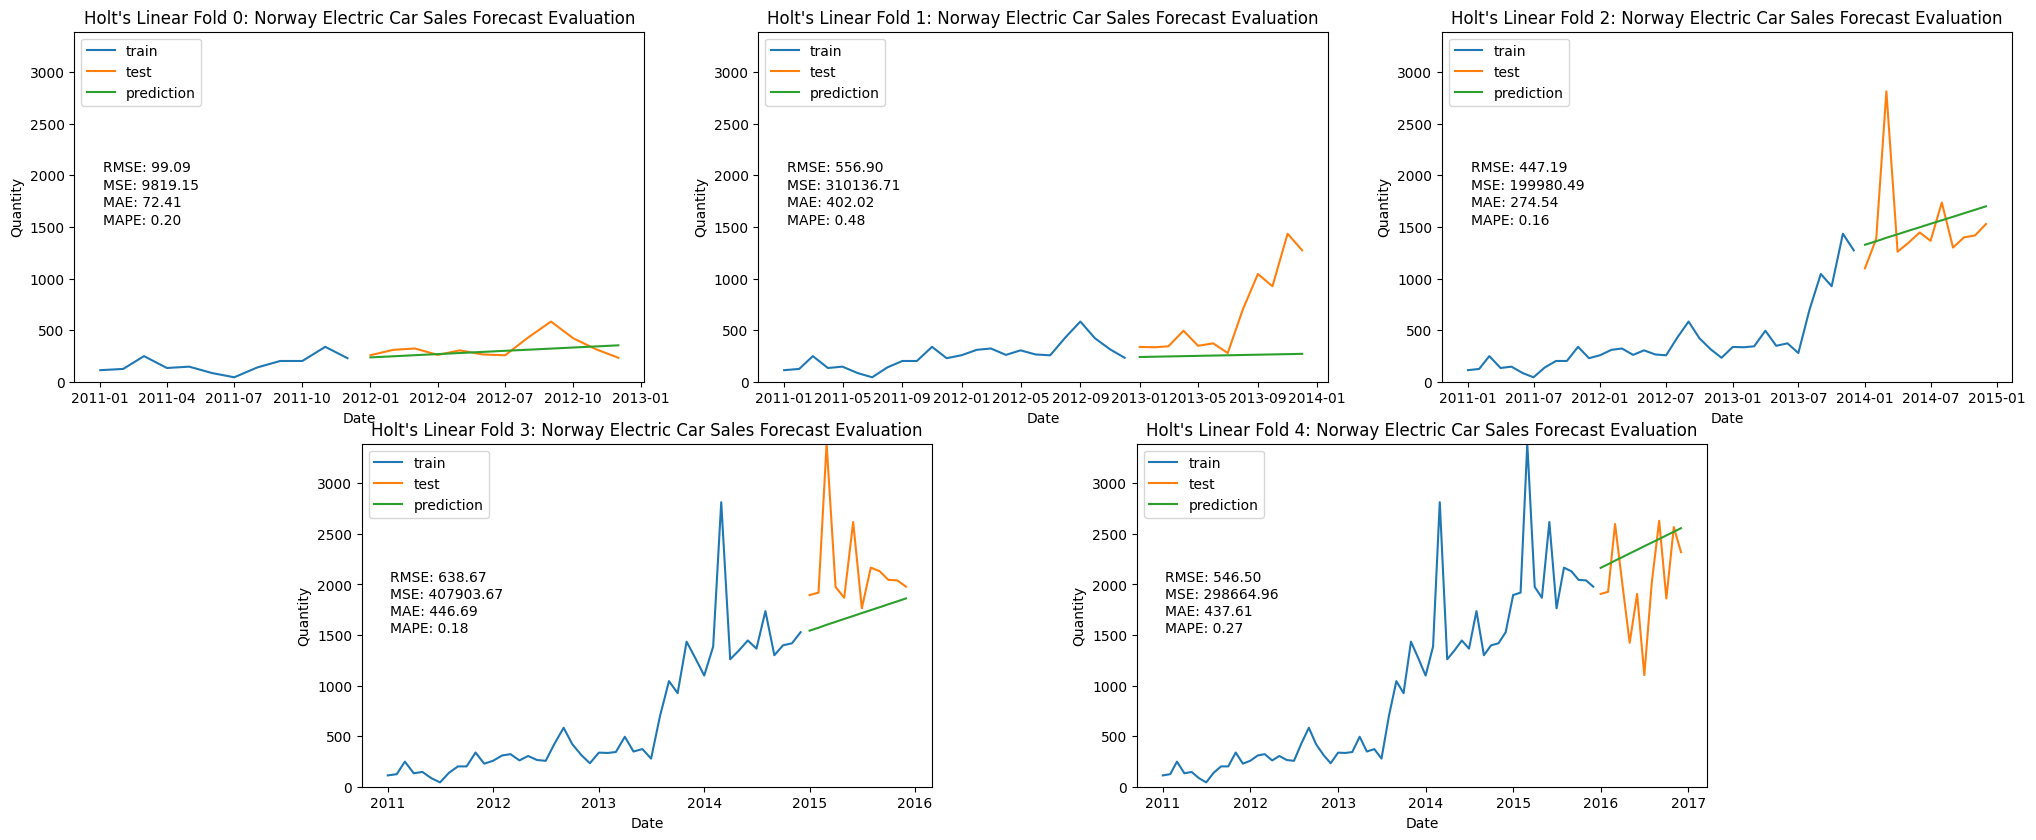

In [ ]:
# evaluate for Holt-linear model

# time series split
from sklearn.model_selection import TimeSeriesSplit
test_size = 12
tscv = TimeSeriesSplit(n_splits = 5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales_QE)):
  cv_train, cv_test = df_car_sales_QE.loc[train_index, :], df_car_sales_QE.loc[test_index, :]                                 # retrieve training set and testing set
  holt_linear_model = ExponentialSmoothing(cv_train['Quantity_Electric'],trend='add').fit()   # call model and fit
  predictions = holt_linear_model.forecast(test_size)                                                                           # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity_Electric'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity_Electric'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity_Electric'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity_Electric'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity_Electric'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity_Electric'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend(loc='upper left')
  axes[i].set_title(f"Holt's Linear Fold {i}: Norway Electric Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, max(df_car_sales_QE.Quantity_Electric)])

  axes[i].text(0.05, 0.6, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.55, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.5, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.45, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("cv_RMSE:", np.mean(rmse), "\ncv_MSE:", np.mean(mse), "\ncv_MAE:", np.mean(mae), "\ncv_MAPE:", np.mean(mape))
print('optimal smoothing level', holt_linear_model.params['smoothing_level'],
      '\noptimal smoothing trend', holt_linear_model.params['smoothing_trend'])

### forecast method 4: ARIMA model

As ARIMA models requires stationarity, stationality of the data is tested with ADFuller test. If data is not stationary, data is differentiated until stationarity is achieved. Typically, differencing is carried out for less than 2 orders of differentiation.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
  result=adfuller(sales)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
  for value,label in zip(result,labels):
      print(label+' : '+str(value) )

  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
  else:
      print("weak evidence against null hypothesis,indicating it is non-stationary ")
  return result

result_ori = adfuller_test(df_car_sales_QE.Quantity_Electric)
print()
result_d1 = adfuller_test(df_car_sales_QE.Quantity_Electric.diff().dropna())   # d = 1 in ARIMA model
print()
result_d2 = adfuller_test(df_car_sales_QE.Quantity_Electric.diff().dropna().diff().dropna())   # d = 2 in ARIMA model


ADF Test Statistic : -0.5060360392309298
p-value : 0.8908332117813351
#Lags Used : 12
Number of Observations : 59
weak evidence against null hypothesis,indicating it is non-stationary 

ADF Test Statistic : -2.834631515954524
p-value : 0.05349464485458003
#Lags Used : 11
Number of Observations : 59
weak evidence against null hypothesis,indicating it is non-stationary 

ADF Test Statistic : -4.6206324570352235
p-value : 0.00011831922002874939
#Lags Used : 11
Number of Observations : 58
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


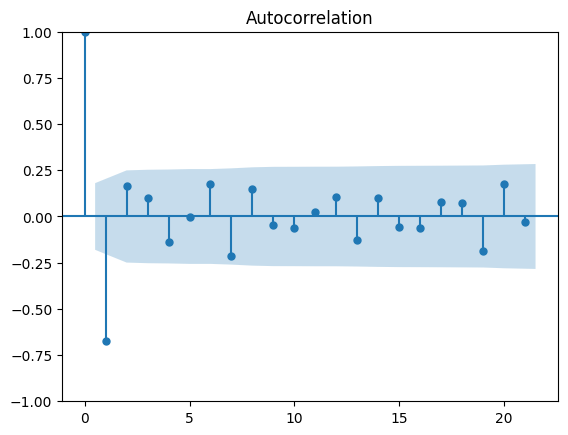

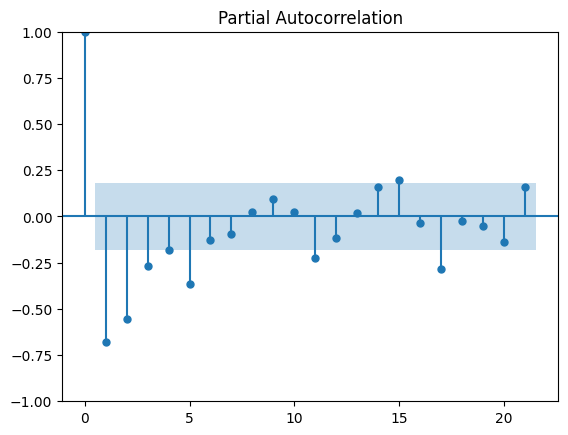

In [ ]:
# acf (autocorrelated function) and pacf (partially-autocorrelated function) are used to determine p and q
# reference: https://blog.devgenius.io/finding-optimal-p-d-and-q-values-for-your-arima-model-94669a909a35
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_d1 = plot_acf(df_car_sales.Quantity.diff().dropna().diff().dropna())     # used to determine q (lag_time forecast error) : 1
pacf_d1 = plot_pacf(df_car_sales.Quantity.diff().dropna().diff().dropna())   # used to determine p (autoregressive term): 3

cv_RMSE: 439.03190002067413 
cv_MSE: 223281.34007360804 
cv_MAE: 317.54018017960067 
cv_MAPE: 0.2365337628011443


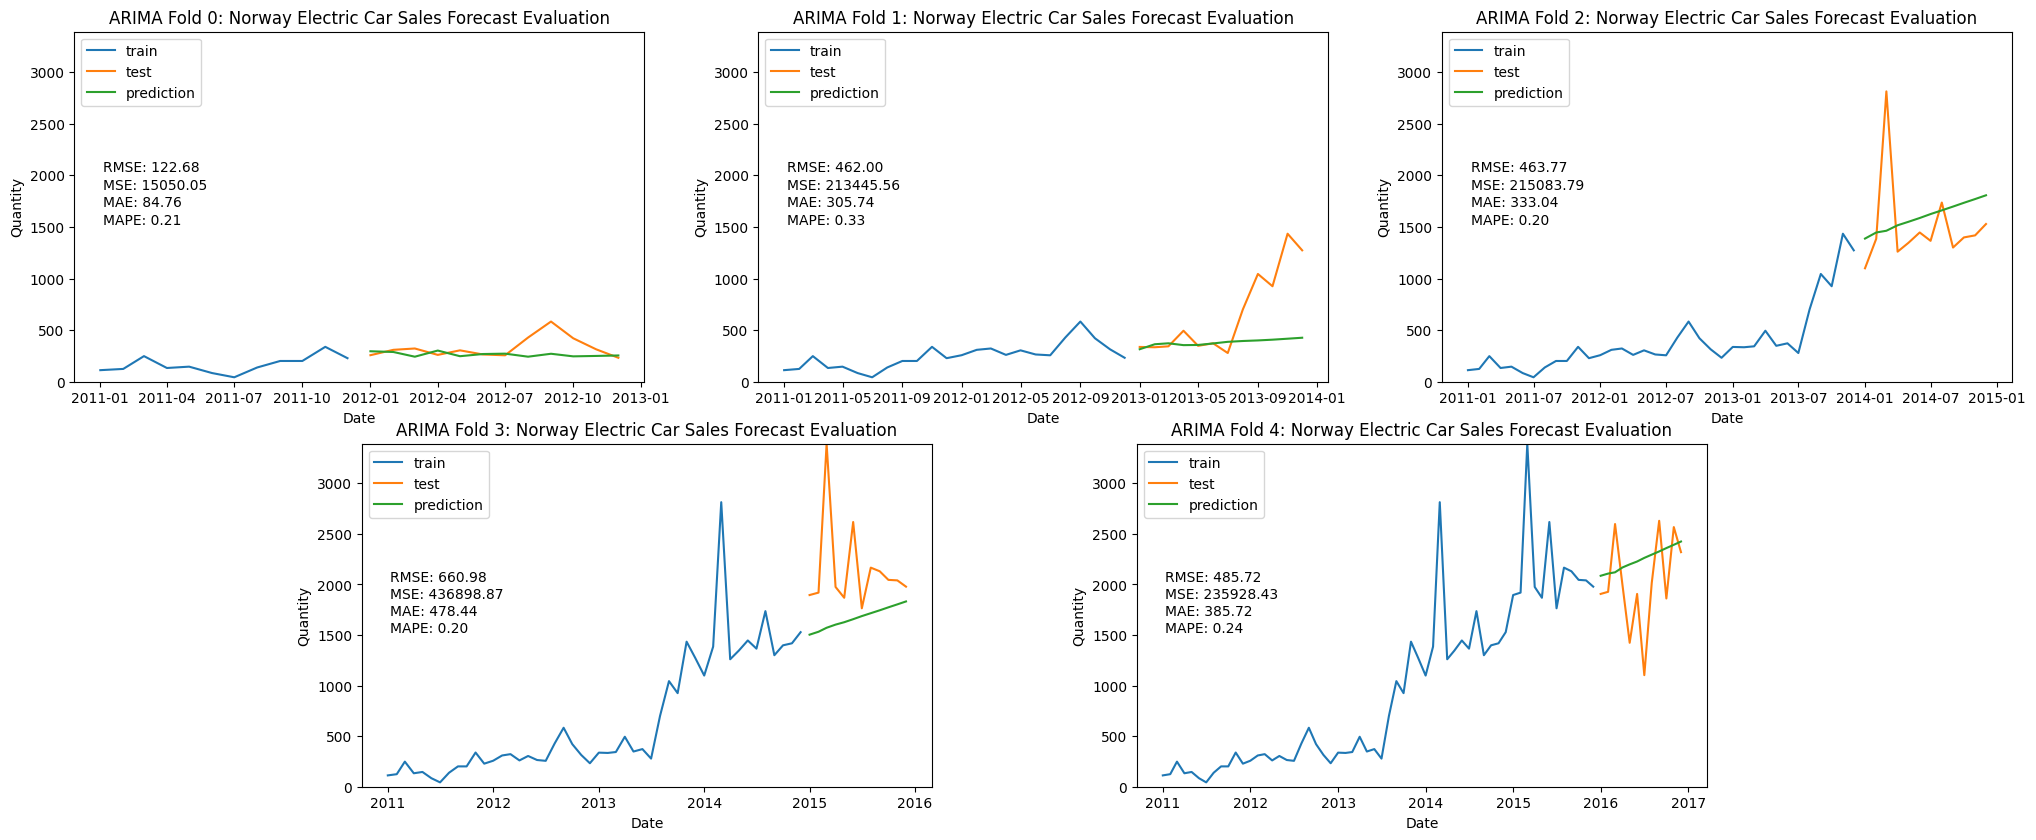

In [ ]:
# evaluate for ARIMA

# time series split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

test_size = 12
tscv = TimeSeriesSplit(n_splits = 5, test_size=test_size)

# subplots
fig, axes = plt.subplots(2,3, figsize=(25,10))
axes = axes.flatten()
axes[5].set_visible(False)
axes[3].set_position([0.24,0.125,0.228,0.343])
axes[4].set_position([0.55,0.125,0.228,0.343])

# cross validation for mae, mse and rmse
pred = []
mse, rmse, mae, mape = [], [], [], []

for i, (train_index, test_index) in enumerate(tscv.split(df_car_sales_QE)):
  cv_train, cv_test = df_car_sales_QE.loc[train_index, :], df_car_sales_QE.loc[test_index, :]             # retrieve training set and testing set
  arima_model = ARIMA(cv_train['Quantity_Electric'], order = [3,2,1]).fit()                                  # call model and fit   (try out different combinations of order and explain)
  predictions = arima_model.forecast(test_size)                                                     # forecast (change this)

  # store evaluation metrics
  mse.append(mean_squared_error(cv_test['Quantity_Electric'], predictions))
  rmse.append(np.sqrt(mean_squared_error(cv_test['Quantity_Electric'], predictions)))
  mae.append(mean_absolute_error(cv_test['Quantity_Electric'], predictions))
  mape.append(mean_absolute_percentage_error(cv_test['Quantity_Electric'], predictions))

  # plot evaluation
  axes[i].plot(cv_train.date, cv_train['Quantity_Electric'], label = 'train')
  axes[i].plot(cv_test.date, cv_test['Quantity_Electric'], label='test')
  axes[i].plot(cv_test.date, predictions, label='prediction')

  axes[i].legend(loc='upper left')
  axes[i].set_title(f"ARIMA Fold {i}: Norway Electric Car Sales Forecast Evaluation")
  axes[i].set_ylabel(f"Quantity")
  axes[i].set_xlabel(f"Date")
  axes[i].set_ylim([0, max(df_car_sales_QE.Quantity_Electric)])

  axes[i].text(0.05, 0.6, f"RMSE: {rmse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.55, f"MSE: {mse[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.5, f"MAE: {mae[i]:.2f}", transform=axes[i].transAxes, fontsize=10)
  axes[i].text(0.05, 0.45, f"MAPE: {mape[i]:.2f}", transform=axes[i].transAxes, fontsize=10)


# print cross validated evaluation results
print("cv_RMSE:", np.mean(rmse), "\ncv_MSE:", np.mean(mse),
      "\ncv_MAE:", np.mean(mae), "\ncv_MAPE:", np.mean(mape))

## Forecast Car Sales and Electric Car Sales (2017)

For car sales, best performing model is simple moving average (SMA). <br>
For electric car sales, best performing model is ARIMA.
<br>

These models are selected for forecast

In [ ]:
start_date = '2017-01-01'
end_date = '2017-12-01'

forecast_date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

print(forecast_date_range)

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')


#### Forecasting Car Sales in 2017

In [ ]:
# smoothen out the report by quarter / by year with simple moving average (to find out about the real trend of EV market share)
window_size = 12

# car sales MA
df_car_sales['12MA_Quantity'] = df_car_sales['Quantity'].rolling(window_size, center=False).mean()
df_car_sales['Forecast_Quantity'] = df_car_sales['12MA_Quantity'].shift()

# Extend for the forecasted years
df_car_sales.tail(3)

,date,Quantity,Pct_Electric,Quantity_Electric,12MA_Quantity,Forecast_Quantity,12MA_Quantity_Electric,Forecast_QE
117,2016-10-01,11932,15.596715,1861.0,12790.416667,12895.833333,1948.083333,1963.416667
118,2016-11-01,13194,19.455813,2567.0,12839.916667,12790.416667,1992.000000,1948.083333
119,2016-12-01,13602,17.048963,2319.0,12883.583333,12839.916667,2020.416667,1992.000000


In [88]:
df_car_sales.date

0     2007-01-01
1     2007-02-01
2     2007-03-01
3     2007-04-01
4     2007-05-01
         ...    
115   2016-08-01
116   2016-09-01
117   2016-10-01
118   2016-11-01
119   2016-12-01
Name: date, Length: 120, dtype: datetime64[ns]

In [87]:
# forecast result 2017
df_car_sales.loc[df_car_sales.date >= pd.to_datetime('2017'), ['date', 'Forecast_QE']]

,date,Forecast_QE


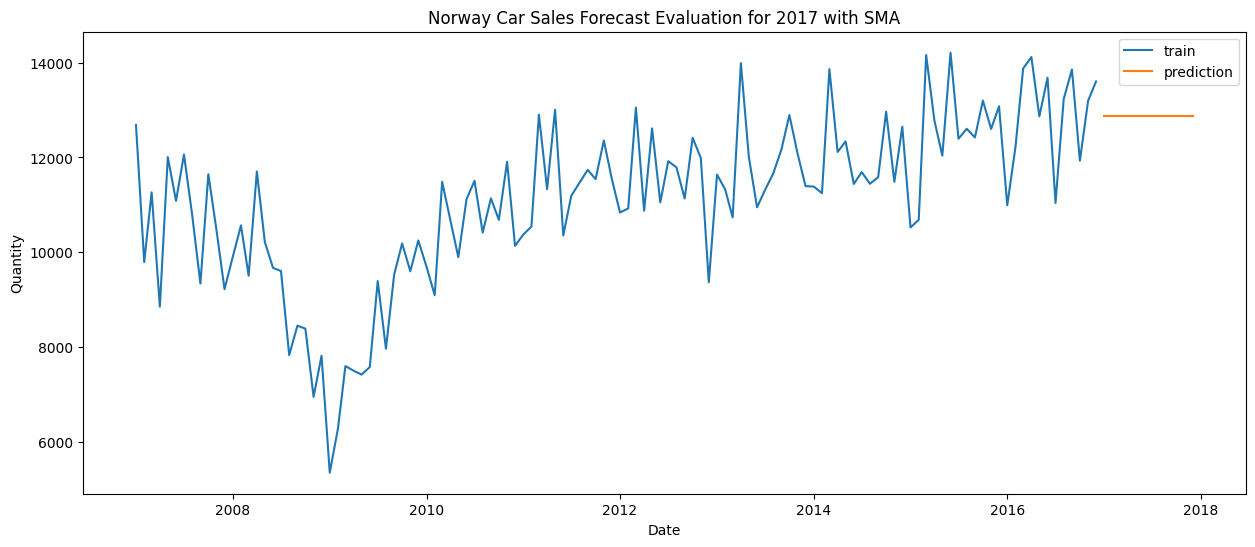

In [103]:
# subplots
fig, axes = plt.subplots(figsize=(15,6))

forecast_horizon =12
cs_predictions = np.array(df_car_sales.loc[:,'12MA_Quantity'].tail(1).tolist() * forecast_horizon)                                                                          # forecast (change this)

# plot evaluation
axes.plot(df_car_sales.date, df_car_sales['Quantity'], label = 'train')
axes.plot(forecast_date_range, cs_predictions, label='prediction')

axes.legend()
axes.set_title(f"Norway Car Sales Forecast Evaluation for 2017 with SMA")
axes.set_ylabel(f"Quantity")
axes.set_xlabel(f"Date")

plt.show()

In [104]:
# car sales forecast
pd.DataFrame(cs_predictions).set_index(forecast_date_range).rename(columns={0: '2017 monthly car sales prediction'})

,2017 monthly car sales prediction
2017-01-01,12883.583333
2017-02-01,12883.583333
2017-03-01,12883.583333
2017-04-01,12883.583333
2017-05-01,12883.583333
2017-06-01,12883.583333
2017-07-01,12883.583333
2017-08-01,12883.583333
2017-09-01,12883.583333
2017-10-01,12883.583333


#### Forecasting Electric Car Sales in 2017

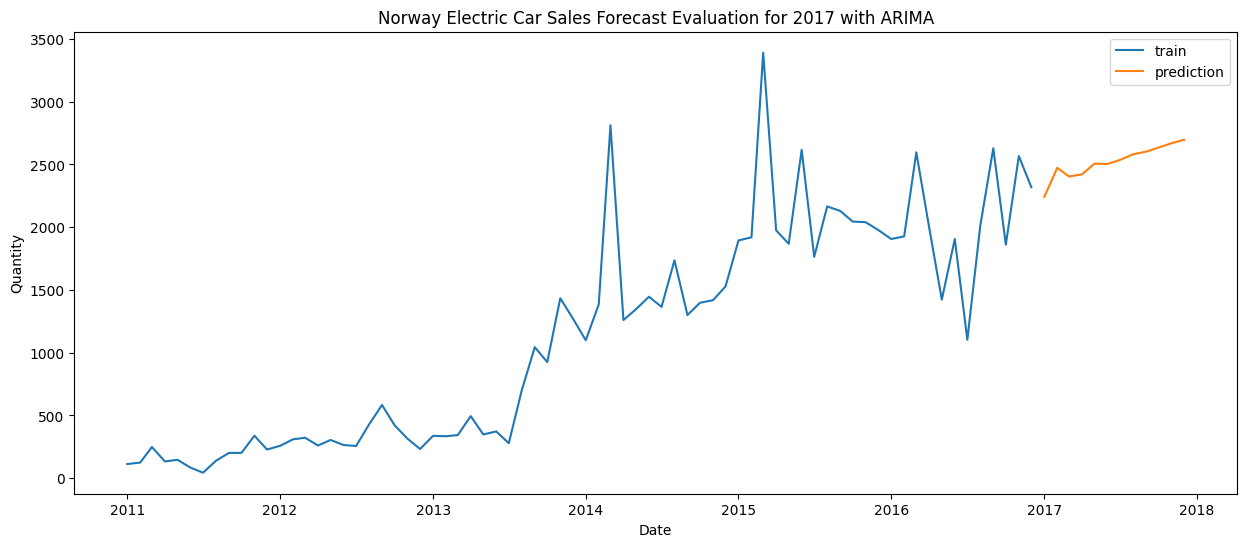

In [106]:
# subplots
fig, axes = plt.subplots(figsize=(15,6))

forecast_horizon =12
arima_model = ARIMA(df_car_sales_QE['Quantity_Electric'], order = [3,2,1]).fit()                                  # call model and fit   (try out different combinations of order and explain)
ev_predictions = arima_model.forecast(forecast_horizon)                                                     # forecast (change this)
                                                                  # forecast (change this)

# plot evaluation
axes.plot(df_car_sales_QE.date, df_car_sales_QE['Quantity_Electric'], label = 'train')
axes.plot(forecast_date_range, ev_predictions, label='prediction')

axes.legend()
axes.set_title(f"Norway Electric Car Sales Forecast Evaluation for 2017 with ARIMA")
axes.set_ylabel(f"Quantity")
axes.set_xlabel(f"Date")

plt.show()

In [109]:
# car sales forecast
pd.DataFrame(ev_predictions).set_index(forecast_date_range).rename(columns={'predicted_mean': '2017 monthly electric car sales prediction'})

,2017 monthly electric car sales prediction
2017-01-01,2242.779951
2017-02-01,2473.573180
2017-03-01,2404.357603
2017-04-01,2421.705508
2017-05-01,2507.053998
2017-06-01,2504.237720
2017-07-01,2536.555781
2017-08-01,2581.700036
2017-09-01,2601.951936
2017-10-01,2634.923273
